In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import reg_helper as RHelper
import pandas as pd

Using TensorFlow backend.


https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0

In [2]:
folder = 'data/'
X = np.load(folder+'X_all.npy')
y = np.load(folder+'y_all.npy').reshape(-1)

In [3]:
# Split entre train y val
X_train = X[:len(X)//2]
y_train = y[:len(y)//2]
X_val = X[len(X)//2:]
y_val = y[len(y)//2:]

In [4]:
from lightgbm import LGBMClassifier

In [5]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
import hyperopt

In [7]:
def objective(params):
    n_estimators = 2000
    clf = LGBMClassifier(
        n_estimators=n_estimators,
        **params
    )
    clf.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds=100, verbose=0)
    accuracy = np.array(clf.score(X_val, y_val))
    return -accuracy

In [8]:
space = {
    'max_depth': hp.choice('max_depth', list(np.arange(1, 31))),
    'learning_rate': hp.loguniform('learning_rate', -6, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -8, -3),
    'min_child_samples': hp.choice('min_child_samples', list(np.arange(1, 20))),
    'min_child_weight': hp.loguniform('min_child_weight', -8, -1)    
}

tpe_trials = Trials()

best = fmin(fn=objective,
            space=space,
            trials = tpe_trials,
            verbose=1,
            algo=hyperopt.tpe.suggest,
            # algo=hyperopt.rand.suggest,
            return_argmin=False,
            max_evals=1000)

100%|██████████| 1000/1000 [01:08<00:00, 14.57it/s, best loss: -0.8305084745762712]


In [38]:
best

{'learning_rate': 0.34354644754470653,
 'max_depth': 2,
 'min_child_samples': 2,
 'min_child_weight': 0.1031928806667034,
 'reg_lambda': 0.003548269540500941}

In [43]:
pd.DataFrame(tpe_trials).head()

,book_time,exp_key,misc,owner,refresh_time,result,spec,state,tid,version
0,2019-08-22 01:01:29.079,None,"{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,2019-08-22 01:01:29.130,"{'loss': -0.5423728813559322, 'status': 'ok'}",None,2,0,0
1,2019-08-22 01:01:29.134,None,"{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,2019-08-22 01:01:29.211,"{'loss': -0.7288135593220338, 'status': 'ok'}",None,2,1,0
2,2019-08-22 01:01:29.216,None,"{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,2019-08-22 01:01:29.277,"{'loss': -0.6101694915254238, 'status': 'ok'}",None,2,2,0
3,2019-08-22 01:01:29.281,None,"{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,2019-08-22 01:01:29.418,"{'loss': -0.6101694915254238, 'status': 'ok'}",None,2,3,0
4,2019-08-22 01:01:29.423,None,"{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,2019-08-22 01:01:29.517,"{'loss': -0.6949152542372882, 'status': 'ok'}",None,2,4,0


In [49]:
pd.DataFrame(tpe_trials.idxs_vals[1]).head(10)

,learning_rate,max_depth,min_child_samples,min_child_weight,reg_lambda
0,0.010840,1,17,0.002119,0.002276
1,0.005852,26,2,0.000665,0.006706
2,0.019014,15,14,0.003460,0.010240
3,0.007212,13,14,0.004763,0.006527
4,0.003836,12,8,0.001328,0.001201
5,0.003581,3,13,0.000744,0.006230
6,0.004217,7,13,0.265072,0.004437
7,0.013399,5,18,0.248311,0.005244
8,0.005547,16,6,0.016108,0.009862
9,0.195889,1,18,0.029162,0.014674


In [10]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['max_depth'],
                            'max_depth': tpe_trials.idxs_vals[1]['max_depth']})
tpe_results.set_index('iteration')
tpe_results.loc[tpe_trials.idxs_vals[0]['learning_rate'], 'learning_rate']  = tpe_trials.idxs_vals[1]['learning_rate']
tpe_results.loc[tpe_trials.idxs_vals[0]['reg_lambda'], 'reg_lambda']  = tpe_trials.idxs_vals[1]['reg_lambda']
tpe_results.loc[tpe_trials.idxs_vals[0]['min_child_samples'], 'min_child_samples']  = tpe_trials.idxs_vals[1]['min_child_samples']
tpe_results.loc[tpe_trials.idxs_vals[0]['min_child_weight'], 'min_child_weight']  = tpe_trials.idxs_vals[1]['min_child_weight']

In [37]:
tpe_results.sort_values('loss').head(10)

,loss,iteration,max_depth,learning_rate,reg_lambda,min_child_samples,min_child_weight
603,-0.830508,603,3,0.187032,0.000370,0,0.367554
789,-0.830508,789,3,0.190602,0.000374,0,0.357932
730,-0.830508,730,3,0.131374,0.000561,0,0.363660
697,-0.830508,697,3,0.119495,0.000481,0,0.259220
759,-0.830508,759,3,0.193532,0.000366,0,0.354658
606,-0.830508,606,3,0.104990,0.000577,0,0.359166
605,-0.830508,605,3,0.185198,0.000542,0,0.326564
612,-0.830508,612,3,0.103564,0.000495,0,0.259548
785,-0.830508,785,3,0.153146,0.000502,0,0.304322
613,-0.830508,613,3,0.202145,0.000477,0,0.363247


Text(0.5, 1.0, 'min_child_weight vs iterations')

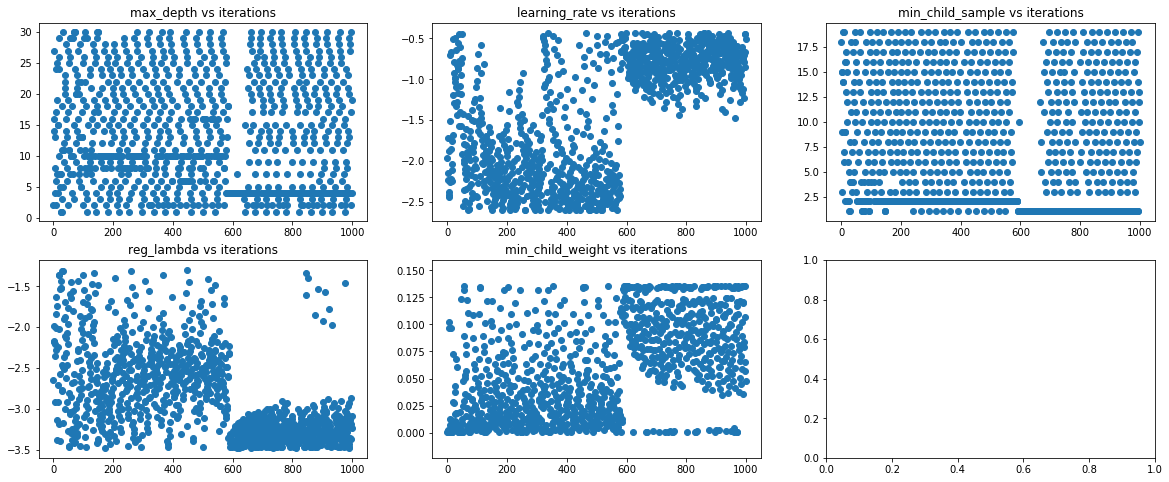

In [54]:
f, ax = plt.subplots(2, 3, figsize=(20,8))
ax = ax.reshape(-1)
ax[0].scatter(tpe_results['iteration'], tpe_results['max_depth']+1)
ax[0].set_title('max_depth vs iterations')
ax[1].scatter(tpe_results['iteration'], np.log10(np.array(tpe_results['learning_rate'].values, dtype='float')))
ax[1].set_title('learning_rate vs iterations')
ax[2].scatter(tpe_results['iteration'], tpe_results['min_child_samples']+1)
ax[2].set_title('min_child_sample vs iterations')
ax[3].scatter(tpe_results['iteration'], np.log10(np.array(tpe_results['reg_lambda'].values, dtype='float')))
ax[3].set_title('reg_lambda vs iterations')
ax[4].scatter(tpe_results['iteration'], np.log10(np.array(tpe_results['min_child_weight'].values + 1, dtype='float')))
ax[4].set_title('min_child_weight vs iterations')
# ax[5].scatter(np.log10(np.array(results_df['param_learning_rate'].values, dtype='float')), results_df['mean_fit_time'].values)
# ax[5].set_title('fit time vs learning_rate')

Text(0.5, 1.0, 'min_child_weight histogram')

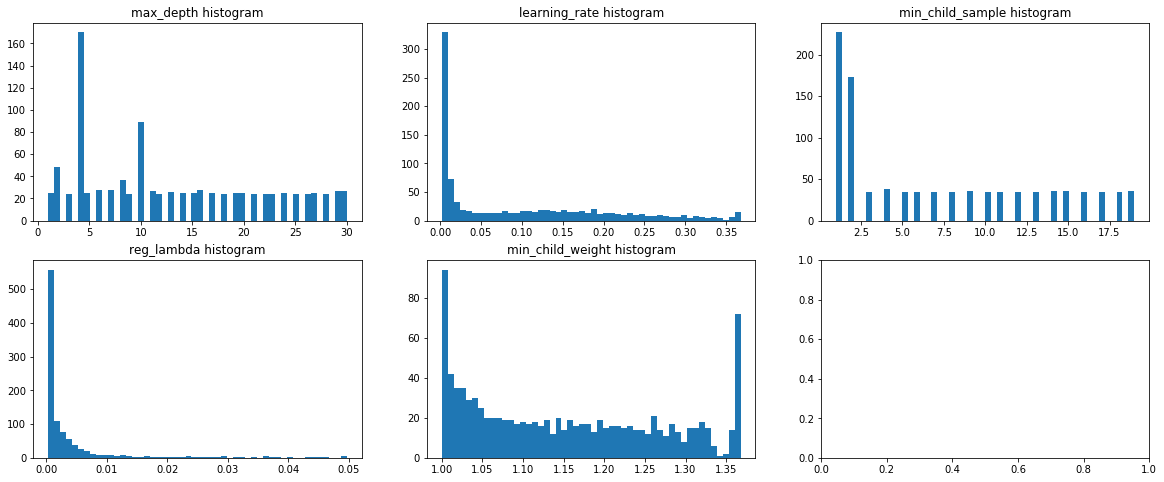

In [31]:
f, ax = plt.subplots(2, 3, figsize=(20,8))
ax = ax.reshape(-1)
ax[0].hist(tpe_results['max_depth']+1, 50)
ax[0].set_title('max_depth histogram')
ax[1].hist(tpe_results['learning_rate'], 50)
ax[1].set_title('learning_rate histogram')
ax[2].hist(tpe_results['min_child_samples']+1, 50)
ax[2].set_title('min_child_sample histogram')
ax[3].hist(tpe_results['reg_lambda'], 50)
ax[3].set_title('reg_lambda histogram')
ax[4].hist(tpe_results['min_child_weight']+1, 50)
ax[4].set_title('min_child_weight histogram')

Text(0.5, 1.0, 'min_child_weight histogram')

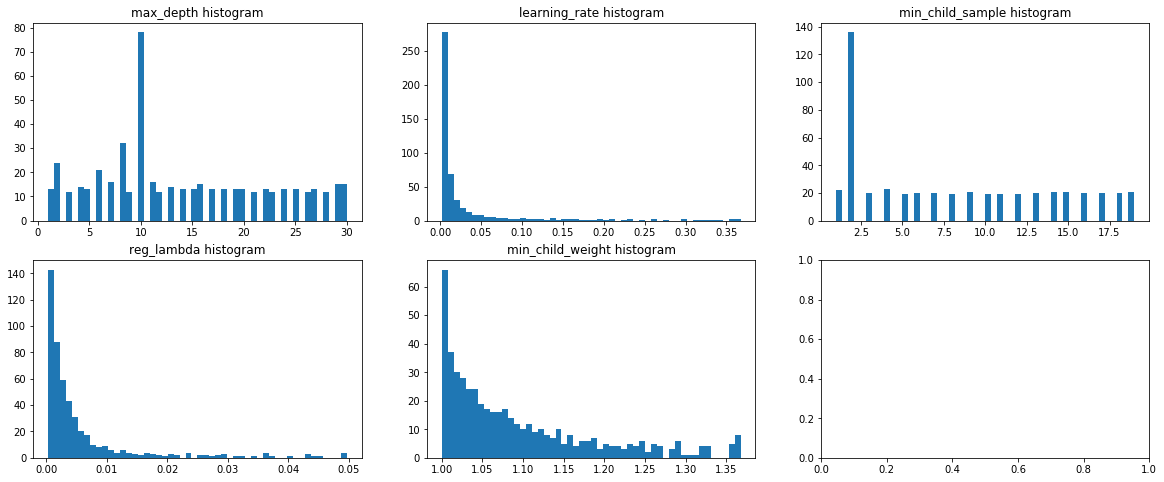

In [35]:
N = 500
f, ax = plt.subplots(2, 3, figsize=(20,8))
ax = ax.reshape(-1)
ax[0].hist(tpe_results['max_depth'][:N]+1, 50)
ax[0].set_title('max_depth histogram')
ax[1].hist(tpe_results['learning_rate'][:N], 50)
ax[1].set_title('learning_rate histogram')
ax[2].hist(tpe_results['min_child_samples'][:N]+1, 50)
ax[2].set_title('min_child_sample histogram')
ax[3].hist(tpe_results['reg_lambda'][:N], 50)
ax[3].set_title('reg_lambda histogram')
ax[4].hist(tpe_results['min_child_weight'][:N]+1, 50)
ax[4].set_title('min_child_weight histogram')

Text(0.5, 1.0, 'min_child_weight histogram')

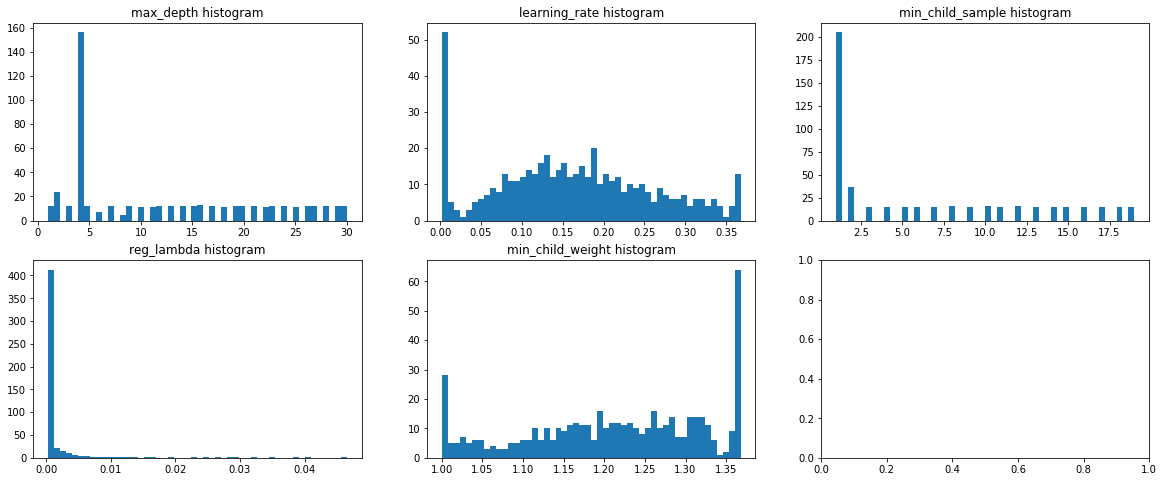

In [36]:
N = 500
f, ax = plt.subplots(2, 3, figsize=(20,8))
ax = ax.reshape(-1)
ax[0].hist(tpe_results['max_depth'][N:]+1, 50)
ax[0].set_title('max_depth histogram')
ax[1].hist(tpe_results['learning_rate'][N:], 50)
ax[1].set_title('learning_rate histogram')
ax[2].hist(tpe_results['min_child_samples'][N:]+1, 50)
ax[2].set_title('min_child_sample histogram')
ax[3].hist(tpe_results['reg_lambda'][N:], 50)
ax[3].set_title('reg_lambda histogram')
ax[4].hist(tpe_results['min_child_weight'][N:]+1, 50)
ax[4].set_title('min_child_weight histogram')

In [14]:
clf = LGBMClassifier(
        n_estimators=2000,
        **best
    )

In [16]:
fit_params={"early_stopping_rounds":100, 
            "eval_set" : [(X_val, y_val)],
            'verbose': 100,
           }

In [17]:
clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.688871
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.440506


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.34354644754470653,
               max_depth=2, min_child_samples=2,
               min_child_weight=0.1031928806667034, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0,
               reg_lambda=0.003548269540500941, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

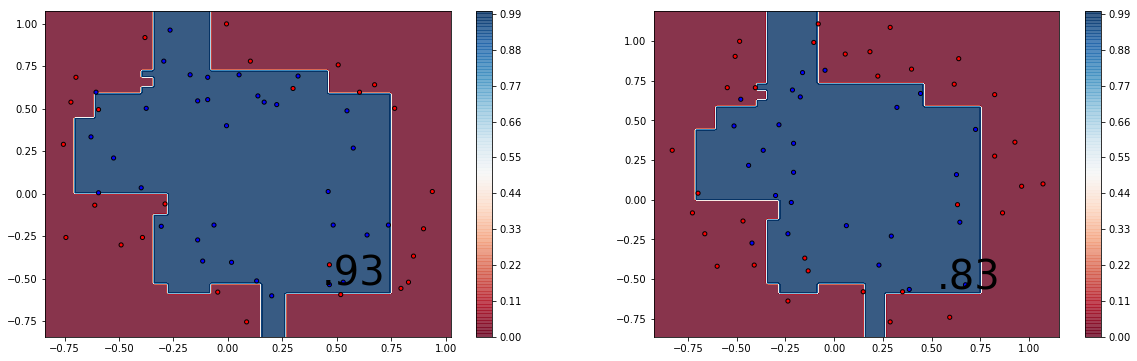

In [20]:
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_val, y_val)
# Graficamos probabilidades en el plano de la combinación de todos los clasificadores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries(X_train, y_train, score_train, clf.predict,  mesh_res=200, ax=ax1, bound_line=False)
RHelper.plot_boundaries(X_val, y_val, score_test, clf.predict,  mesh_res=200, ax=ax2, bound_line=False)